In [19]:
from typing import List, Tuple
import kenlm
import torch
import torchaudio
import torch.nn.functional as F
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import heapq
from jiwer import wer
import Levenshtein
import matplotlib.pyplot as plt
import pandas as pd
import time
import os


class Wav2Vec2Decoder:
    def __init__(
            self,
            model_name="facebook/wav2vec2-base-960h",
            lm_model_path="lm/3-gram.pruned.1e-7.arpa.gz",
            beam_width=3,
            alpha=1.0,
            beta=1.0
        ):
        self.processor = Wav2Vec2Processor.from_pretrained(model_name)
        self.model = Wav2Vec2ForCTC.from_pretrained(model_name)

        self.vocab = {i: c for c, i in self.processor.tokenizer.get_vocab().items()}
        self.blank_token_id = self.processor.tokenizer.pad_token_id
        self.word_delimiter = self.processor.tokenizer.word_delimiter_token
        self.beam_width = beam_width
        self.alpha = alpha
        self.beta = beta
        self.lm_model = kenlm.Model(lm_model_path) if lm_model_path and os.path.exists(lm_model_path) else None

    def greedy_decode(self, logits: torch.Tensor) -> str:
        pred_ids = torch.argmax(logits, dim=-1).tolist()
        prev_token = None
        tokens = []
        for token_id in pred_ids:
            if token_id != prev_token and token_id != self.blank_token_id:
                tokens.append(token_id)
            prev_token = token_id
        return "".join(self.vocab[i].replace("|", " ") for i in tokens)

    def beam_search_decode(self, logits: torch.Tensor, return_beams: bool = False):
        T, V = logits.size()
        log_probs = F.log_softmax(logits, dim=-1)

        beams = [([], 0.0)]
        for t in range(T):
            new_beams = []
            for seq, score in beams:
                for v in range(V):
                    new_seq = seq + [v]
                    new_score = score + log_probs[t, v].item()
                    new_beams.append((new_seq, new_score))
            beams = heapq.nlargest(self.beam_width, new_beams, key=lambda x: x[1])

        final_beams = []
        for seq, score in beams:
            merged = []
            prev = None
            for token in seq:
                if token != prev and token != self.blank_token_id:
                    merged.append(token)
                prev = token
            final_beams.append((merged, score))

        if return_beams:
            return final_beams
        else:
            best_seq = max(final_beams, key=lambda x: x[1])[0]
            return "".join(self.vocab[i].replace("|", " ") for i in best_seq)

    def beam_search_with_lm(self, logits: torch.Tensor) -> str:
        if not self.lm_model:
            raise ValueError("KenLM model required for LM shallow fusion")

        T, V = logits.size()
        log_probs = F.log_softmax(logits, dim=-1)

        beams = [([], 0.0)]
        for t in range(T):
            new_beams = []
            for seq, score in beams:
                for v in range(V):
                    token = self.vocab[v].replace("|", " ")
                    new_seq = seq + [v]
                    text = "".join(self.vocab[i].replace("|", " ") for i in new_seq).strip()
                    lm_score = self.lm_model.score(text)
                    combined_score = score + log_probs[t, v].item() + self.alpha * lm_score + self.beta
                    new_beams.append((new_seq, combined_score))
            beams = heapq.nlargest(self.beam_width, new_beams, key=lambda x: x[1])

        best_seq = max(beams, key=lambda x: x[1])[0]
        merged = []
        prev = None
        for token in best_seq:
            if token != prev and token != self.blank_token_id:
                merged.append(token)
            prev = token
        return "".join(self.vocab[i].replace("|", " ") for i in merged)

    def lm_rescore(self, beams: List[Tuple[List[int], float]]) -> str:
        rescored = []
        for seq, score in beams:
            text = "".join(self.vocab[i].replace("|", " ") for i in seq).strip()
            lm_score = self.lm_model.score(text)
            total_score = score + self.alpha * lm_score + self.beta * text.count(" ")
            rescored.append((text, total_score))
        best_text = max(rescored, key=lambda x: x[1])[0]
        return best_text

    def decode(self, audio_input: torch.Tensor, method: str = "greedy") -> str:
        inputs = self.processor(audio_input, return_tensors="pt", sampling_rate=16000)
        with torch.no_grad():
            logits = self.model(inputs.input_values.squeeze(0)).logits[0]

        if method == "greedy":
            return self.greedy_decode(logits)
        elif method == "beam":
            return self.beam_search_decode(logits)
        elif method == "beam_lm":
            return self.beam_search_with_lm(logits)
        elif method == "beam_lm_rescore":
            beams = self.beam_search_decode(logits, return_beams=True)
            return self.lm_rescore(beams)
        else:
            raise ValueError("Invalid decoding method. Choose one of 'greedy', 'beam', 'beam_lm', 'beam_lm_rescore'.")


Running with LM: lm/3-gram.pruned.1e-7.arpa.gz


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running with LM: lm/3-gram.pruned.1e-7.arpa.gz


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running with LM: lm/3-gram.pruned.1e-7.arpa.gz


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running with LM: lm/3-gram.pruned.1e-7.arpa.gz


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running with LM: lm/3-gram.pruned.1e-7.arpa.gz


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running with LM: lm/3-gram.pruned.1e-7.arpa.gz


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running with LM: lm/3-gram.pruned.1e-7.arpa.gz


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running with LM: lm/3-gram.pruned.1e-7.arpa.gz


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


                                                   levenshtein       wer  \
method beam_width alpha beta audio                                         
beam   5          0.5   0.0  examples/sample1.wav     0.039024  0.078947   
                             examples/sample2.wav     0.000000  0.000000   
                             examples/sample3.wav     0.006061  0.027027   
                             examples/sample4.wav     0.019231  0.073171   
                             examples/sample5.wav     0.005952  0.031250   
...                                                        ...       ...   
greedy 10         1.0   1.0  examples/sample4.wav     0.019231  0.073171   
                             examples/sample5.wav     0.005952  0.031250   
                             examples/sample6.wav     0.272727  0.636364   
                             examples/sample7.wav     0.188889  0.437500   
                             examples/sample8.wav     0.147368  0.294118   

           

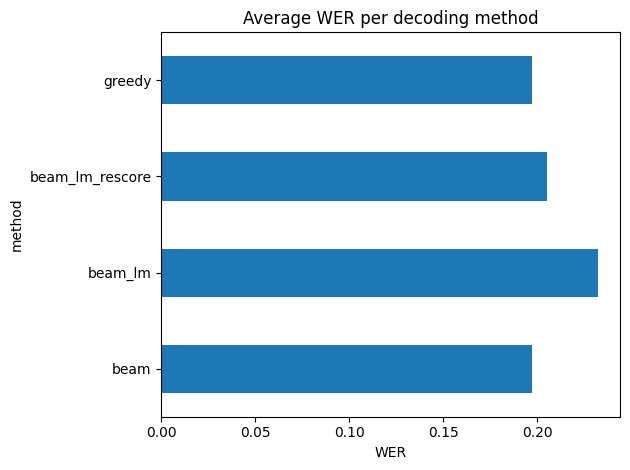

In [20]:
def test(decoder, audio_path, true_transcription, results_df):
    audio_input, sr = torchaudio.load(audio_path)
    assert sr == 16000, "Audio sample rate must be 16kHz"

    for d_strategy in ["greedy", "beam", "beam_lm", "beam_lm_rescore"]:
        start = time.time()
        transcript = decoder.decode(audio_input, method=d_strategy)
        elapsed = time.time() - start
        lev_dist = Levenshtein.distance(true_transcription, transcript.strip()) / len(true_transcription)
        wer_score = wer(true_transcription, transcript.strip())
        results_df.append({
            "audio": audio_path,
            "method": d_strategy,
            "beam_width": decoder.beam_width,
            "alpha": decoder.alpha,
            "beta": decoder.beta,
            "levenshtein": lev_dist,
            "wer": wer_score,
            "time_sec": elapsed
        })

if __name__ == "__main__":
    test_samples = [
        ("examples/sample1.wav", "IF YOU ARE GENEROUS HERE IS A FITTING OPPORTUNITY FOR THE EXERCISE OF YOUR MAGNANIMITY IF YOU ARE PROUD HERE AM I YOUR RIVAL READY TO ACKNOWLEDGE MYSELF YOUR DEBTOR FOR AN ACT OF THE MOST NOBLE FORBEARANCE"),
        ("examples/sample2.wav", "AND IF ANY OF THE OTHER COPS HAD PRIVATE RACKETS OF THEIR OWN IZZY WAS UNDOUBTEDLY THE MAN TO FIND IT OUT AND USE THE INFORMATION WITH A BEAT SUCH AS THAT EVEN GOING HALVES AND WITH ALL THE GRAFT TO THE UPPER BRACKETS HE'D STILL BE ABLE TO MAKE HIS PILE IN A MATTER OF MONTHS"),
        ("examples/sample3.wav", "GUESS A MAN GETS USED TO ANYTHING HELL MAYBE I CAN HIRE SOME BUMS TO SIT AROUND AND WHOOP IT UP WHEN THE SHIPS COME IN AND BILL THIS AS A REAL OLD MARTIAN DEN OF SIN"),
        ("examples/sample4.wav", "IT WAS A TUNE THEY HAD ALL HEARD HUNDREDS OF TIMES SO THERE WAS NO DIFFICULTY IN TURNING OUT A PASSABLE IMITATION OF IT TO THE IMPROVISED STRAINS OF I DIDN'T WANT TO DO IT THE PRISONER STRODE FORTH TO FREEDOM"),
        ("examples/sample5.wav", "MARGUERITE TIRED OUT WITH THIS LONG CONFESSION THREW HERSELF BACK ON THE SOFA AND TO STIFLE A SLIGHT COUGH PUT UP HER HANDKERCHIEF TO HER LIPS AND FROM THAT TO HER EYES"),
        ("examples/sample6.wav", "AT THIS TIME ALL PARTICIPANTS ARE IN A LISTEN ONLY MODE"),
        ("examples/sample7.wav", "THE INCREASE WAS MAINLY ATTRIBUTABLE TO THE NET INCREASE IN THE AVERAGE SIZE OF OUR FLEETS"),
        ("examples/sample8.wav", "OPERATING SURPLUS IS A NON CAP FINANCIAL MEASURE WHICH IS DEFINED AS FULLY IN OUR PRESS RELEASE"),
    ]

    all_results = []
    for beam_width in [5, 10]:
        for alpha in [0.5, 1.0]:
            for beta in [0.0, 1.0]:
                for lm_path in ["lm/3-gram.pruned.1e-7.arpa.gz", "lm/3-gram.arpa.gz"]:
                    if not os.path.exists(lm_path): continue
                    print("Running with LM:", lm_path)
                    decoder = Wav2Vec2Decoder(
                        beam_width=beam_width,
                        alpha=alpha,
                        beta=beta,
                        lm_model_path=lm_path
                    )
                    for audio_path, target in test_samples:
                        test(decoder, audio_path, target, all_results)

    df = pd.DataFrame(all_results)
    print(df.groupby(["method", "beam_width", "alpha", "beta", "audio"])[["levenshtein", "wer", "time_sec"]].mean())
    df.groupby(["method"])["wer"].mean().plot(kind="barh", title="Average WER per decoding method")
    plt.xlabel("WER")
    plt.tight_layout()
    plt.show()